# Stock price prediction

Contents
1. Introduction
2. EDA + preprocessing
3. Building LSTM model + evalation + generalisation
4. Prediction + Submission

# Introduction

In the financial landscape, the pursuit of accurately predicting stock prices remains a challenge. This project aims to contribute to this endeavor by exploring the efficacy of Long-Short Term Memory (LSTM) models, a type of recurrent neural network, in forecasting stock prices.

The motivation behind choosing LSTM models lies in their ability to capture complex sequential dependencies within time-series data, making them well-suited for the dynamic and non-linear nature of stock market trends. We seek to not only navigate the intricate patterns inherent in financial data but also to optimize information gain from historical stock trends.



**Goal**

Make a short-term hourly prediction for the prices of public US companies' stocks including Apple Inc. (AAPL), Tesla Inc. (TSLA), and Nvidia Corporation (NVDA), for one day (on 13/11).

We will explore from a data scientist's perspective. (since I have zero economic background...)

# 2. EDA
This part covers:
- Yfinance data collection and preprocessing
- Data exploration using mpf, a financial visualisation toolkit.

## 2.1 Data import
The related database is obtained from Yahoo Finance (yf), While other platforms like Alpha Vantage provide better features, yf is open-source and free, also it has high granularity as short as 1 minute.

Remarks when parsing arguments:
- A relatively short interval is used for short-term hourly prediction to capture intraday patterns with high granularity. Historical data is downloaded and stored as csv.
- Data starting from past month is used as database for relevance.
- The closing price can be adjusted as a new column for corporate actions like stock splits, dividends, etc. We parse 'auto_adjusted = False' since we opt for prediction accuracy, not investment based on its economic value.

In [ ]:
# get data from yahoo
!pip install yfinance
!pip install mplfinance # for plotting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.5 MB/s eta 0:00:00


In [197]:
# to read stock data
import yfinance as yf
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr

yf.pdr_override() #override data source

# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # visualisations
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('Solarize_Light2')
%matplotlib inline
import mplfinance as mpf

#model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

In [198]:
# Desired stock symbols and corresponding company names
symbols = ['AAPL', 'TSLA', 'NVDA']
companies = ['APPLE', 'TESLA', 'NVIDIA']

all_data = pd.DataFrame()  # Create an empty DataFrame to store the combined data
interval = '2m'            # Define the time interval (e.g., '5m' for 5 minutes)
start_date = '2023-10-01'  # desired start date
end_date = '2023-11-10'    # desired end date

for symbol, company in zip(symbols, companies):
    # Create a Yahoo Finance Ticker object
    ticker = yf.Ticker(symbol)

    # Retrieve intraday data for the specified date range
    data = ticker.history(period='1d', interval=interval, start=start_date, end=end_date,
                          actions = True, # get dividend & stock split
                          auto_adjust = False
                          )

    # Add a 'Company' column with the company name
    data['Company'] = company

    # Concatenate the data to the 'all_data' DataFrame
    all_data = pd.concat([all_data, data])

# Save the combined data to a CSV file
all_data.to_csv('yahoo_finance_intraday_data.csv', index=True)

## 2.2 Data cleaning

Before cleaning, we give an overview of the collected data. For each timestamp, it records the opening and closing prices, the highest and lowest prices, volume, dividends and stocksplits of each company.

- *Volume* is the total number of shares at a specific period, representing the market activity and liquidity. This can be useful to predict real time stock movement. We will further look at the correlations with stock prices.
- *Dividends* are the payments made by the company to its shareholders on a regular basis, usually quarterly
- *Stock splits* is how the company divides its existing shares into multiple new shares.


According to domain knowledge, dividends and stock splits are relevant for longer-term investment strategy, which may not be primary factors for affecting stock price.  

In [199]:
all_data.head(10)

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Company
Datetime,,,,,,,,,
2023-10-02 09:30:00-04:00,171.220001,172.380005,170.929993,172.300003,172.300003,1853591,0.0,0.0,APPLE
2023-10-02 09:32:00-04:00,172.315002,172.970001,172.149994,172.779999,172.779999,730605,0.0,0.0,APPLE
2023-10-02 09:34:00-04:00,172.759995,173.179993,172.729996,173.040100,173.040100,738457,0.0,0.0,APPLE
2023-10-02 09:36:00-04:00,173.050003,173.112106,172.820007,172.820007,172.820007,511703,0.0,0.0,APPLE
2023-10-02 09:38:00-04:00,172.835007,173.199997,172.835007,173.035004,173.035004,397019,0.0,0.0,APPLE
2023-10-02 09:40:00-04:00,173.046494,173.089996,172.850006,172.979996,172.979996,345073,0.0,0.0,APPLE
2023-10-02 09:42:00-04:00,172.986496,173.116501,172.919998,173.009995,173.009995,230613,0.0,0.0,APPLE
2023-10-02 09:44:00-04:00,173.020004,173.210007,172.919998,173.169998,173.169998,494673,0.0,0.0,APPLE
2023-10-02 09:46:00-04:00,173.169998,173.250000,172.869995,172.873199,172.873199,383383,0.0,0.0,APPLE


In [200]:
all_data.shape # df shape

(16935, 9)

Data type of columns for prices and stocks are floats while the volume is in integer type.

In [201]:
all_data.info() # general info

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16935 entries, 2023-10-02 09:30:00-04:00 to 2023-11-09 15:58:00-05:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          16935 non-null  float64
 1   High          16935 non-null  float64
 2   Low           16935 non-null  float64
 3   Close         16935 non-null  float64
 4   Adj Close     16935 non-null  float64
 5   Volume        16935 non-null  int64  
 6   Dividends     16935 non-null  float64
 7   Stock Splits  16935 non-null  float64
 8   Company       16935 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 1.3+ MB


Based on the summary, the descriptive statistics are similar.

- For dividends and stock splits, all of them carry the value of zero, since the shares are distributed with a long time interval.  It is not aaccessible for the analysis, it is therefore removed.
- For stats goruped by company, the range , std, etc. are different. They require invidual scaler in later preprpocessing.

In [202]:
# Summary Stats
all_data.describe()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
count,16935.000000,16935.000000,16935.000000,16935.000000,16935.000000,1.693500e+04,16935.0,16935.0
mean,282.425088,282.713105,282.135945,282.427322,282.427322,3.496791e+05,0.0,0.0
std,115.005625,115.133724,114.876282,115.007875,115.007875,3.652647e+05,0.0,0.0
min,165.774994,165.860001,165.669998,165.774994,165.774994,5.579000e+03,0.0,0.0
25%,178.587898,178.667198,178.503654,178.589645,178.589645,1.521990e+05,0.0,0.0
50%,220.789993,221.005005,220.550003,220.780106,220.780106,2.489590e+05,0.0,0.0
75%,423.064957,423.549942,422.569992,423.053543,423.053543,4.271205e+05,0.0,0.0
max,482.119995,482.299988,481.711090,482.109985,482.109985,1.335802e+07,0.0,0.0


In [358]:
# Group by company to describe
all_data.groupby('Company').describe(include='all')

Open                                                             \
          count        mean        std         min         25%         50%   
Company                                                                      
APPLE    5655.0  175.478963   4.194635  165.774994  172.369949  176.011902   
NVIDIA   5655.0  439.540659  20.794448  393.158295  422.960007  440.404999   
TESLA    5625.0  231.988073  22.495607  194.529999  214.100006  220.789993   

                                   High              ...       Close  \
                75%         max   count        mean  ...         75%   
Company                                              ...               
APPLE    178.589996  184.000305  5655.0  175.584060  ...  178.595001   
NVIDIA   457.156799  482.119995  5655.0  439.998450  ...  457.160004   
TESLA    254.419998  268.654999  5625.0  232.289304  ...  254.440002   

                     Volume                                                   \
                max   count           mean            std      min       25%   
Company                                                                        
APPLE    184.005005  5655.0  240966.347657  247769.012471  29214.0  135291.5   
NVIDIA   482.109985  5655.0  217541.751370  198377.102535  32691.0  121118.0   
TESLA    268.669891  5625.0  591813.825244  460831.442194   5579.0  352371.0   

                                         
              50%       75%         max  
Company                                  
APPLE    185385.0  268660.5   6449193.0  
NVIDIA   172951.0  254300.5   5922598.0  
TESLA    481064.0  692754.0  13358022.0  

[3 rows x 40 columns]

In [203]:
# Drop the 'Dividends' and 'Stock Splits' columns from the DataFrame
all_data = all_data.drop(['Dividends', 'Stock Splits'], axis=1)

Upon removing the above attributes, the adjusted closing price is found to be the same as the closing price, and it is dropped as well.
It is possible that the data is not accessible when it involves corporate actions.

In [204]:
# Check if 'Close' is the same as 'Adj Close' for all values
all_close_prices = (all_data['Close'] == all_data['Adj Close']).all()

if all_close_prices:
    print("The 'Close' is the same as 'Adj Close' for all values.")
else:
    print("There are differences between 'Close' and 'Adj Close'.")

all_data = all_data.drop(['Adj Close'], axis=1)

# Sort DataFrame by date for sanity check
all_data = all_data.sort_values('Datetime')

The 'Close' is the same as 'Adj Close' for all values.


## 2.3 Data visualisation

Due to the time-series nature of data, we question how the data changes over time, and identify patterns occured over time for each company. Since we are analysing data from three companies from the tech field, we will also see whether they are correlated.
We use the package *mpl-finance* which is primarily used for visualisation of financial data.

### 2.3.1 Mid-price

First, we use mid-price presentation within time interval for plot, assuming that it does not have an extreme volatility.
- Broadly, the three trends are generally similar, but the price trend of Apple and Nvidia has a closer proximity. We will investigate the degree of correlation.

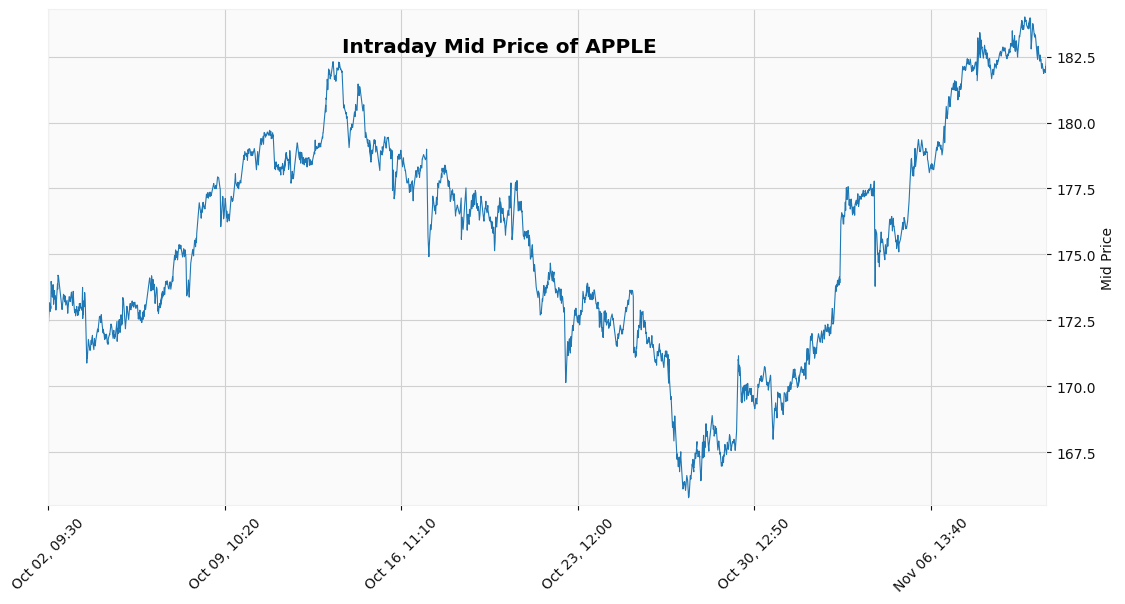

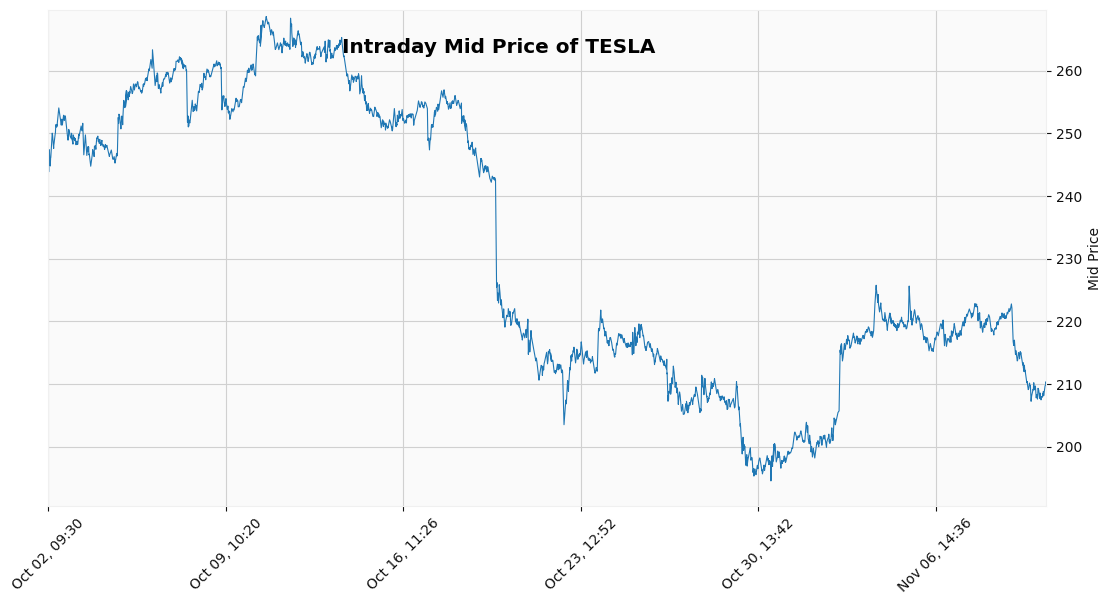

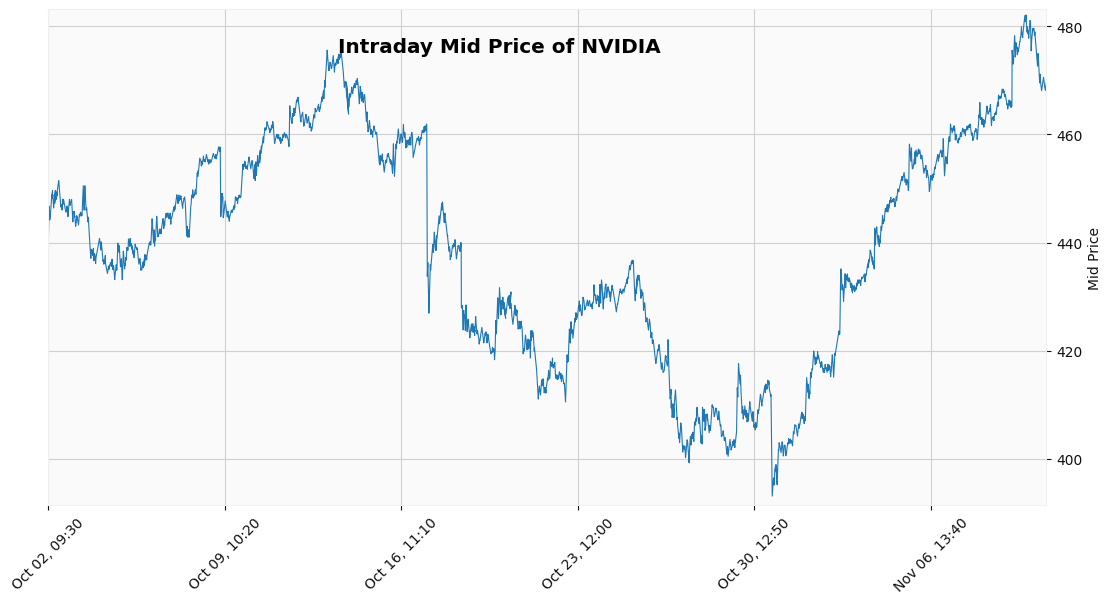

In [205]:
# three companies
company_names = all_data['Company'].unique()

for company_name in company_names:
    company_data = all_data[all_data['Company'] == company_name].copy()  # Create a copy to avoid warnings
    # Filter out weekends
    company_data = company_data[company_data.index.weekday < 5]

    # Create a subplot for the midprice using mplfinance
    mpf.plot(
        company_data,
        type='line',
        ylabel='Mid Price',
        style='yahoo',
        figratio=(4, 2),
        show_nontrading=False,  # Do not show non-trading days
        tight_layout=True,
        title=f"Intraday Mid Price of {company_name}"
    )

plt.show()


### 2.3.2 Datapoints

To further look at how well the datapoints for each column capture the real time trends, we plot the opening, closing, highest and lowest price over time.
- These four attributes overlapping each other well, meaning a sufficient resolution.
- For Nvidia and Tesla, the fluctuations within each time interval are larger around October 29th.

/usr/local/lib/python3.10/dist-packages/mplfinance/plotting.py:438: UserWarning: 



  warnings.warn('\n\n ================================================================= '+


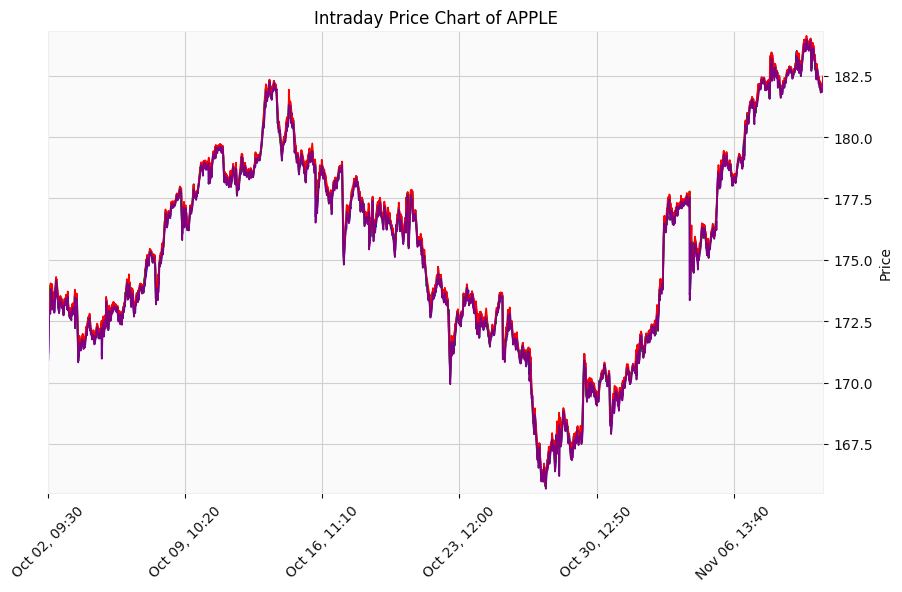

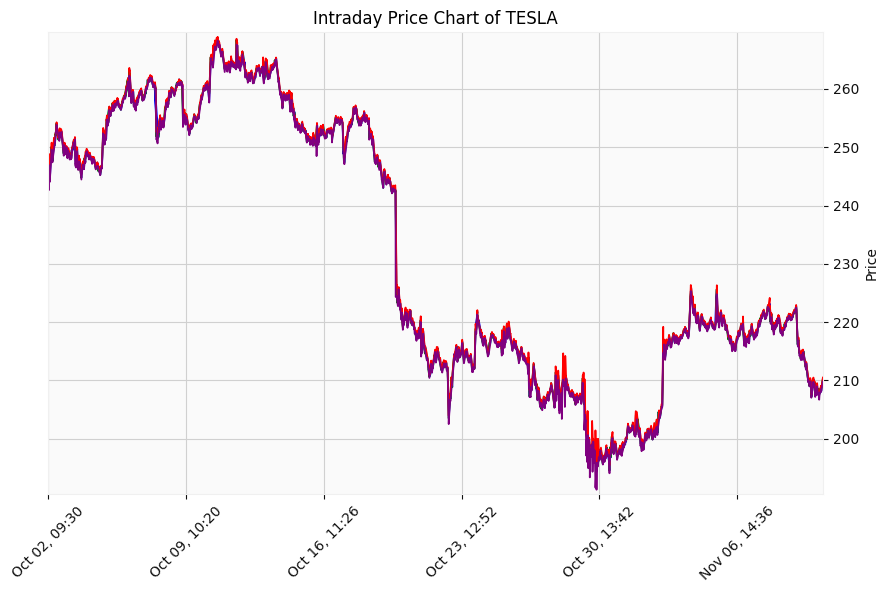

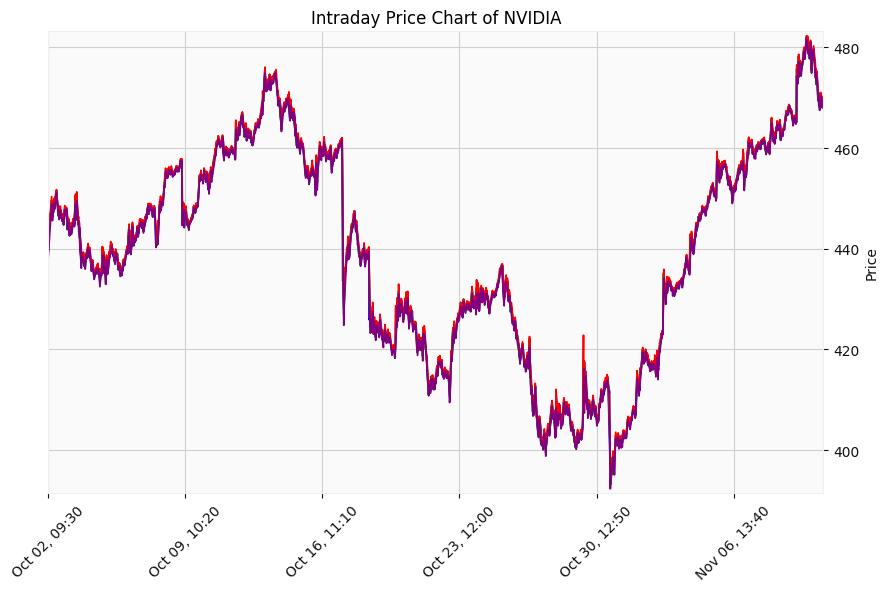

In [206]:
# Loop through each company and create a subplot with overlaid lines for opening, closing, high, and low prices
for company_name in company_names:
    company_data = all_data[all_data['Company'] == company_name].copy()  # Create a copy to avoid warnings
    # Filter out weekends
    company_data = company_data[company_data.index.weekday < 5]

    # Create separate axes for opening, closing, high, and low lines
    fig, ax = plt.subplots(figsize=(10, 6))

    # Overlay opening, closing, high, and low lines using mplfinance
    ap_open = mpf.make_addplot(company_data['Open'], panel=0, color='blue', secondary_y=False, ax=ax)
    ap_close = mpf.make_addplot(company_data['Close'], panel=0, color='green', secondary_y=False, ax=ax)
    ap_high = mpf.make_addplot(company_data['High'], panel=0, color='red', secondary_y=False, ax=ax)
    ap_low = mpf.make_addplot(company_data['Low'], panel=0, color='purple', secondary_y=False, ax=ax)

    mpf.plot(
        company_data,
        type='line',
        ylabel='Price',
        style='yahoo',
        figratio=(4, 2),
        show_nontrading=False,  # Do not show non-trading days
        tight_layout=True,
        ax=ax,
        addplot=[ap_open, ap_close, ap_high, ap_low]  # Pass the list of addplot objects
    )

    ax.set_title(f"Intraday Price Chart of {company_name}")

plt.show()


###2.3.3 Closing price and Volume
The closing price of each day acts as a snapshot of market sentiment and investors' consensus. This offers insights into price trends, volatility, and momentum, all of which are essential for forecasting future price movements.

Stock buyers usually probe from the latest price for decision making of transactions. Therefore, analyzing the relationship between volume and closing price provides insights about market participation and potential indications of trend reversals or continuations of stock price.

We utilise candlestick charts for this observation.
- Green volume bars suggest an 'up' day. In this context, the closing price is higher than that in the pervious minutes interval, and vice versa for red bars.
- Top and bottom of a bar represents either the open or closing price, depending on whether it is bullish (closing > opening) or bearish (closing < opening).
- The tips of stick represents the highest and lowest price at within the time interval.

Remarks:
- Volume seems to spike periodically at every stock market day. These intraday spikes can be due to market orders, reactions to overnight developments and price discovery affecting decision making.
  - High volume on an up day may indicate higher buying interest, whereas on a down day it suggests strong selling pressure.
  - Low volume during a price increase or decrease may indicate a lack of assurance for buying.

-  The overall trend since last month for each company has 2 - 3 waves of volume influx and ebb.

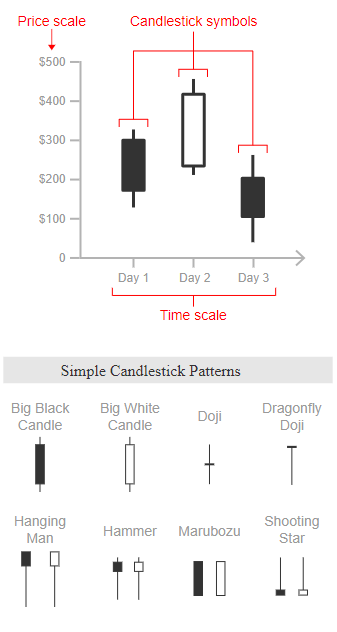

diagram reference: https://www.kaggle.com/code/thebrownviking20/everything-you-can-do-with-a-time-series

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


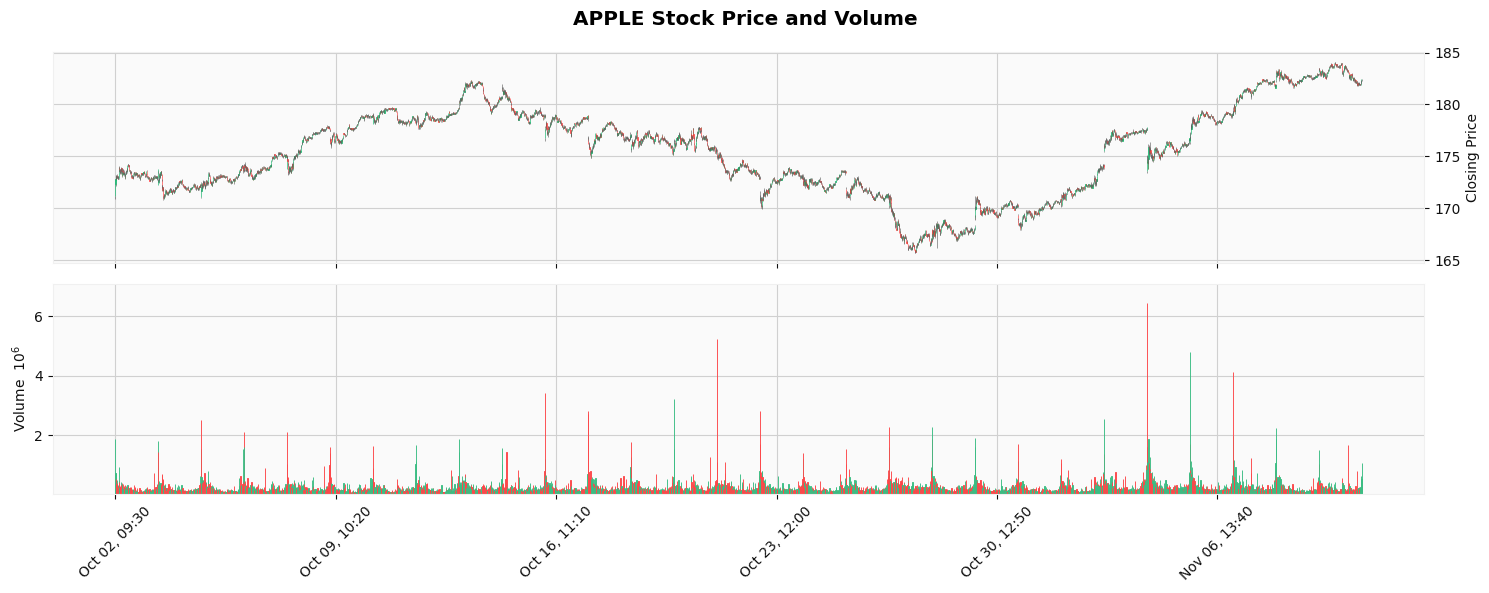

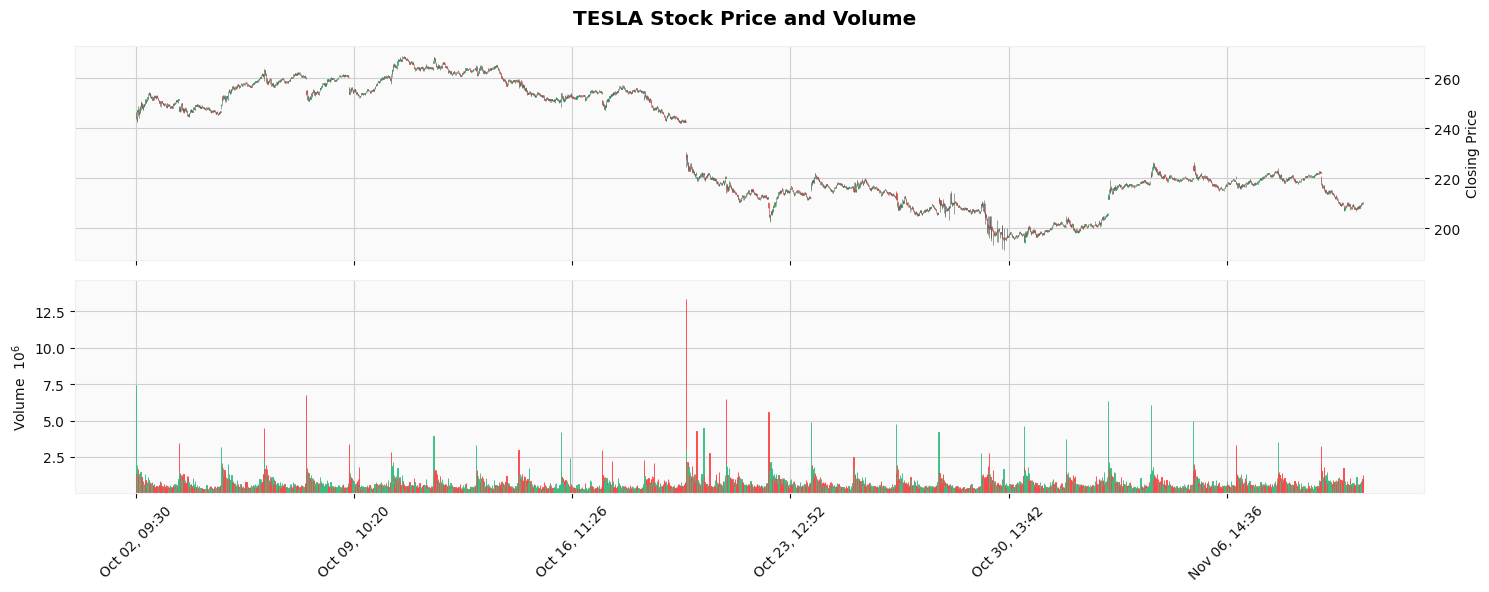

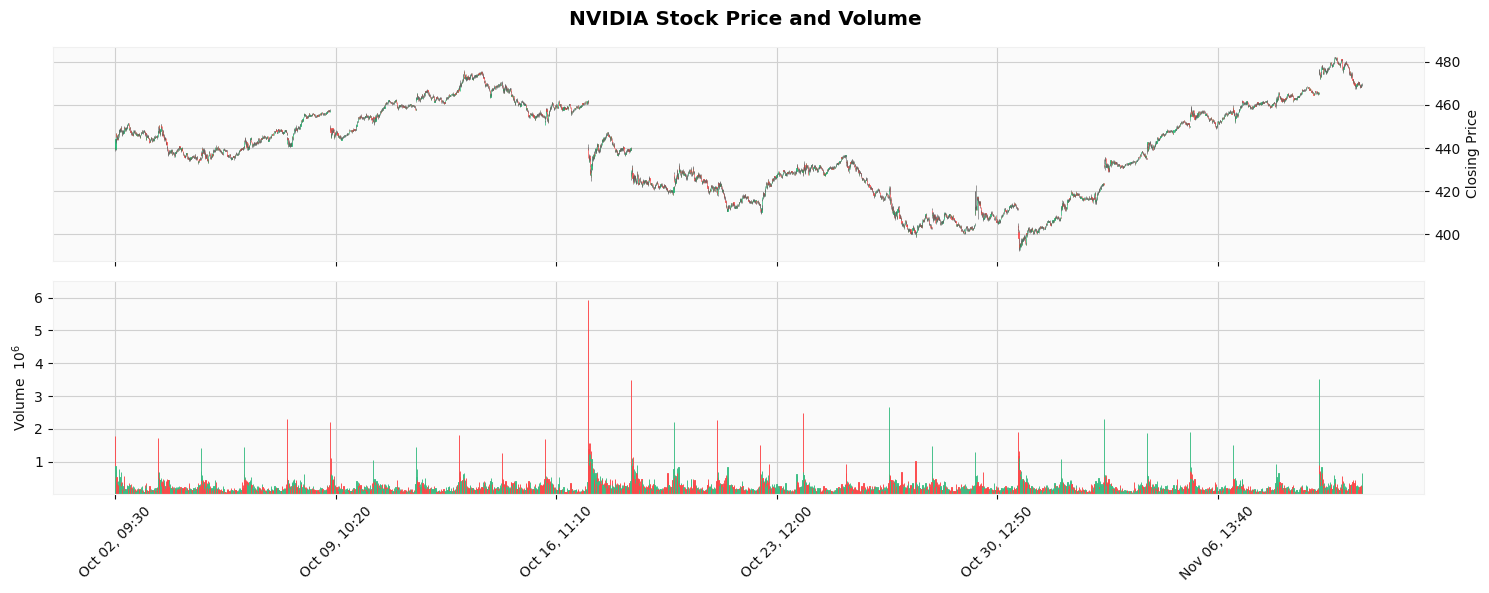

In [207]:
# Loop through each company and create a subplot with candlestick chart for closing price at the top and volume as bar chart at the bottom
for company_name in company_names:
    company_data = all_data[all_data['Company'] == company_name].copy()  # Create a copy to avoid warnings

    # Filter out weekends
    company_data = company_data[company_data.index.weekday < 5]

    # Create a subplot with two y-axes
    fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

    # Plot closing price as candlestick chart at the top and volume as bar chart at the bottom
    mpf.plot(
        company_data,
        ax=ax[0],
        type='candle',  # Set type to 'candle' for candlestick chart
        ylabel='Closing Price',
        style='yahoo',
        show_nontrading=False,  # Do not show non-trading days
        volume=ax[1],  # Specify the volume subplot
    )

    plt.suptitle(f"{company_name} Stock Price and Volume")
    plt.tight_layout()
    plt.show()


To visualise the current trend in the past 3 days:

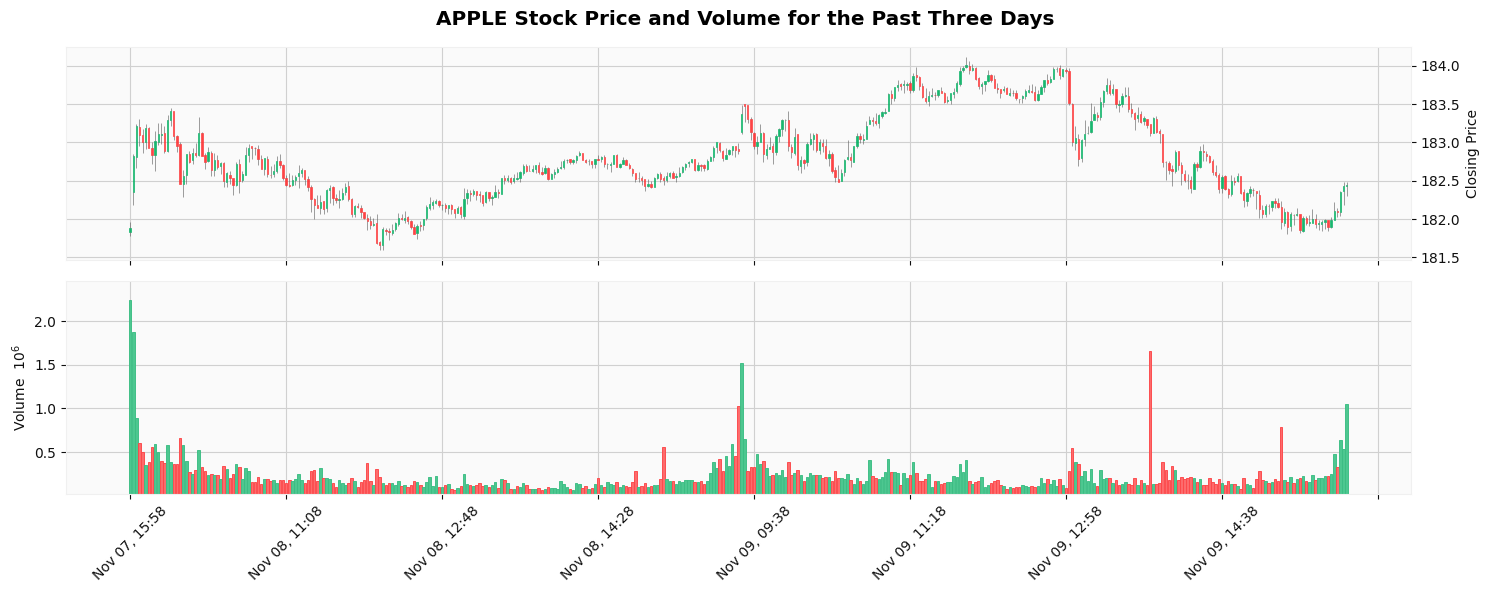

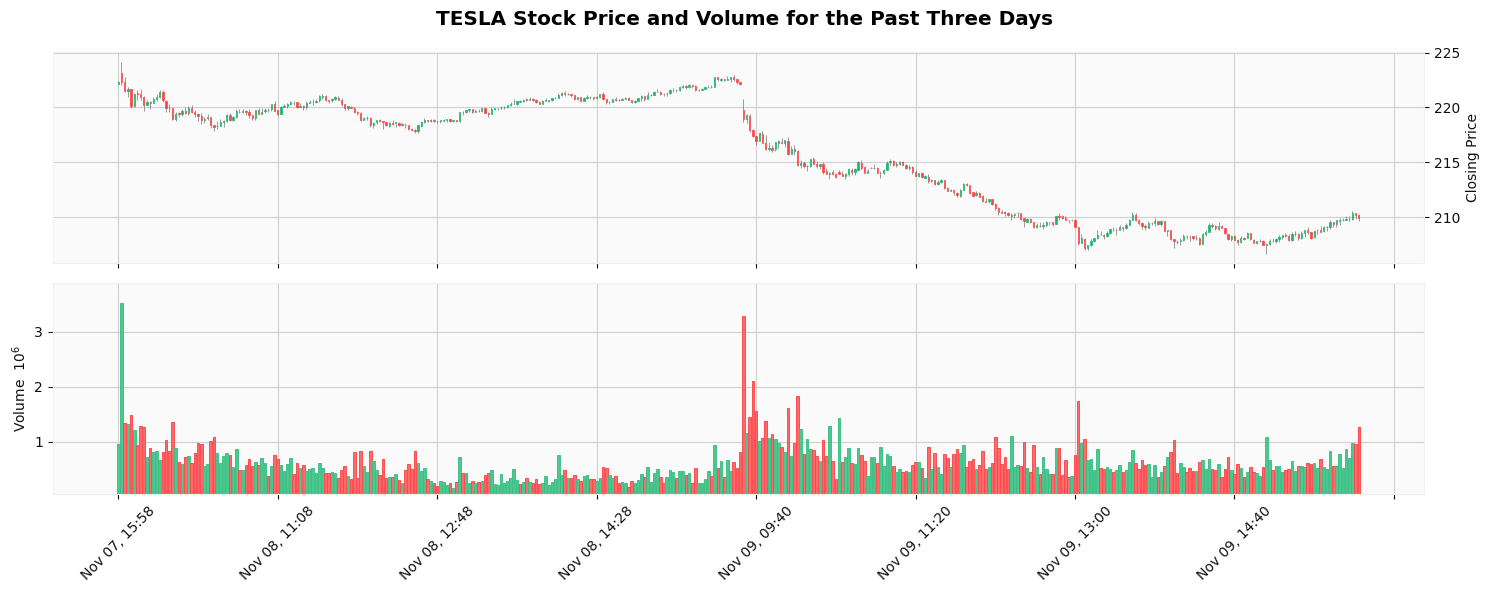

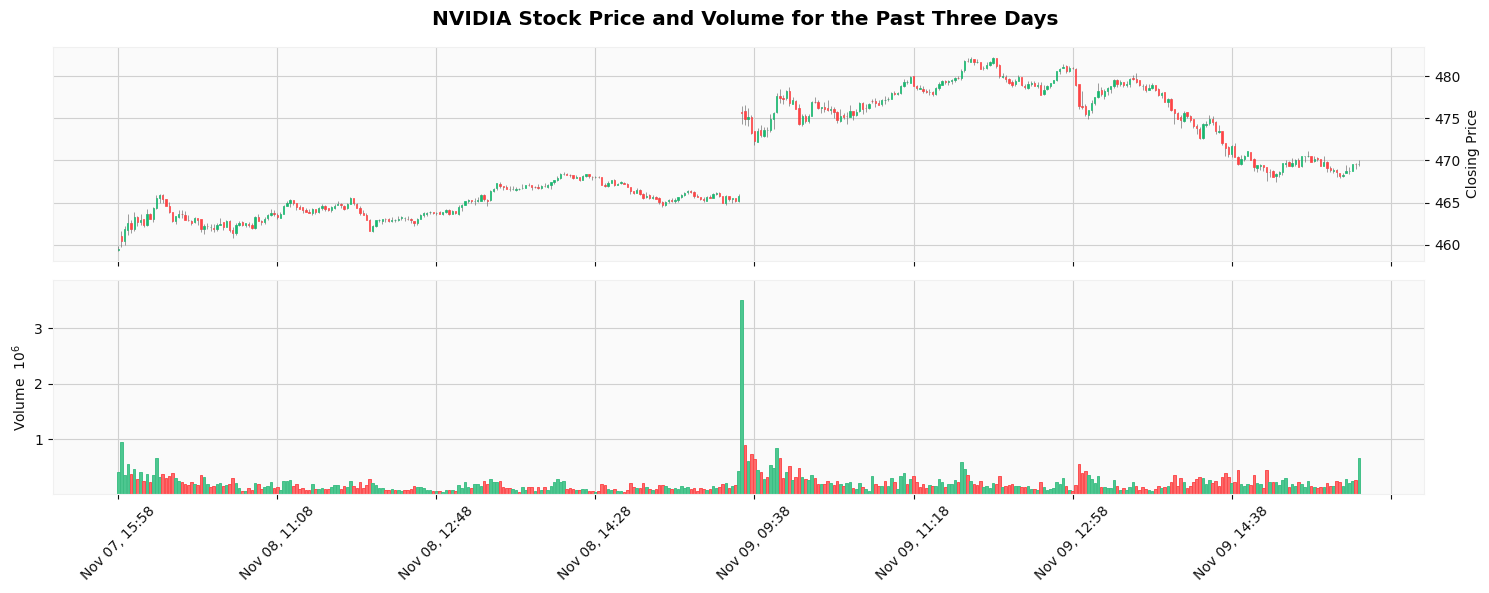

In [208]:
# Loop through each company
for company_name in company_names:
    # Filter data for the past three days
    end_date = all_data.index.max()  # Get the latest date in the dataset
    start_date = end_date - pd.DateOffset(days=2)  # Calculate the start date for the past three days
    company_data = all_data[(all_data['Company'] == company_name) & (all_data.index >= start_date)].copy()

    # Filter out weekends
    company_data = company_data[company_data.index.weekday < 5]

    # Create a subplot with two y-axes
    fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

    # Plot closing price as candlestick chart at the top and volume as bar chart at the bottom
    mpf.plot(
        company_data,
        ax=ax[0],
        type='candle',  # Set type to 'candle' for candlestick chart
        ylabel='Closing Price',
        style='yahoo',
        show_nontrading=False,  # Do not show non-trading days
        volume=ax[1],  # Specify the volume subplot
    )

    plt.suptitle(f"{company_name} Stock Price and Volume for the Past Three Days")
    plt.tight_layout()
    plt.show()


**Correlations between these two attributes**





### 2.3.4 Inter-correlation between stocks

Identifying potential correlated trends can aid developing a more robust predictive model, thus understanding broader market dynamics and potential effects between tech fields. Here we will normalise the plots to make them comparable.
- The correlations between NVIDIA and Apple is high (r = 0.882).
- Correlation between Tesla and the other two are low with Apple (r = 0.405-0.407) and NVIDIA (r = 0.591-0.594)

Other than building 3 separate models, it is worth trying out building 2 models by grouping Apple and NVIDIA as one training data for generalisation, and analyse Tesla stocks separately.

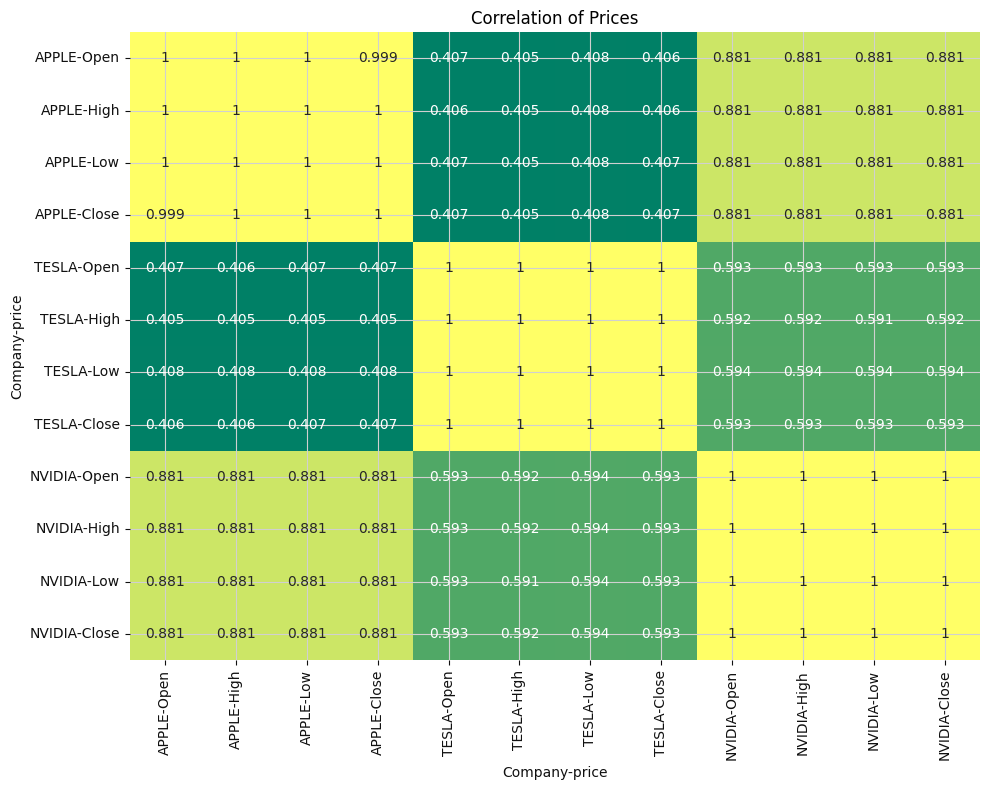

In [425]:
# create dictionary for easier grouping and plotting
prices = {}
for company_name in company_names:
    company_data = all_data[all_data['Company'] == company_name].copy()
    prices[company_name] = company_data[['Open', 'High', 'Low', 'Close']]

# Create DataFrame from the prices dictionary for plotting
prices_df = pd.concat(prices, axis=1)

# normlising the prices using Min-Max scaling
scaler = MinMaxScaler(feature_range = (0,1))
prices_df_scaled = scaler.fit_transform(prices_df)

# Convert the scaled prices back to a DataFrame
prices_df_scaled = pd.DataFrame(prices_df_scaled, columns=prices_df.columns)

# Calculate the correlation matrix for all prices
correlation_matrix_all = prices_df_scaled.corr()

# Plot the correlation matrix for all prices
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_all, annot=True, fmt=".3g", cmap='summer', cbar=False)
plt.title('Correlation of Prices')
plt.xlabel('Company-price')
plt.ylabel('Company-price')

plt.tight_layout()
plt.show()


# 3. LSTM model

This part covers:
- LSTM model building and optimisation
- Performance evaluation using MSE and generalisation


## 3.1 Data preprocessing

Based on initial data analysis, we generate **3 approaches** for building model for evaluation:
1. A generalised model trained on all data
  - Since this only outputs one datapoint for all companies each hour, this can be set as baseline.  
2. Three models for each companys' data
   - This can provide better prediction for capturing the individual company features.
3. Combining Apple and NVIDIA data for training
  - Due to high correlation between these trends.

As for volume as attribute, it is put at the end of the section.



In [215]:
# defined function for splitting and scaling
def split_and_scale_data(all_data, companies, scaler, include_volume=True, train_ratio=0.7):
    # Ensure companies is a list
    if not isinstance(companies, list):
        companies = [companies]

    # Extract data for the specified companies
    df_selected = all_data[all_data['Company'].isin(companies)].copy()
    df_selected.groupby('Company') # to parse sequential data

    # Check if the 'Volume' column is present and whether to include it
    if 'Volume' in df_selected.columns and not include_volume:
        df_selected.drop(columns=['Company', 'Volume'], inplace=True)
    else:
        df_selected.drop(columns=['Company'], inplace=True)
    # Scale the features
    scaled_data = scaler.fit_transform(df_selected)

    # Perform time series splitting based on 'Date'
    cutoff_index = int(len(scaled_data) * train_ratio)
    train_data = scaled_data[:cutoff_index, :]
    test_data = scaled_data[cutoff_index:, :]

    return train_data, test_data


**Data Scaling**

We use minmax scaling so that the model learns patterns without being sensitive to absolute values of stock prices.

- For approach 1, we scale data by each company to fit into characteristics of entire dataset, with assumption of feature similarity across all companies.

- For approach 2, individual scaling helps preserve individuality.


In [236]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

## Approach 1 : dataset for trainng on all data
train_all, test_all = split_and_scale_data(all_data, ['NVIDIA','APPLE','TESLA'], scaler, include_volume=False)
print('Train size of all data:', len(train_all), '. Train size of all data:', len(test_all))

## Approach 2 : trained separately
train_apple, test_apple = split_and_scale_data(all_data, 'APPLE', scaler, include_volume=False)
print("Length of train_apple:", len(train_apple), "Length of test_apple:", len(test_apple))

train_tesla, test_tesla = split_and_scale_data(all_data, 'TESLA', scaler, include_volume=False)
print("Length of train_tesla:", len(train_tesla), "Length of test_tesla:", len(test_tesla))

train_nvidia, test_nvidia = split_and_scale_data(all_data, 'NVIDIA', scaler, include_volume=False)
print("Length of train_nvidia:", len(train_nvidia), "Length of test_nvidia:", len(test_nvidia))

# Approach 3 : combining apple and nvidia
train_appl_nvda, test_appl_nvda = split_and_scale_data(all_data, ['NVIDIA','APPLE'], scaler, include_volume=False)
print("Length of train_appl_nvda:", len(train_appl_nvda), "Length of test_appl_nvda:", len(test_appl_nvda))

Train size of all data: 11854 . Train size of all data: 5081
Length of train_apple: 3958 Length of test_apple: 1697
Length of train_tesla: 3937 Length of test_tesla: 1688
Length of train_nvidia: 3958 Length of test_nvidia: 1697
Length of train_appl_nvda: 7916 Length of test_appl_nvda: 3394


In [296]:
# Function to create sequences for time series data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(0,len(data) - seq_length + 1):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Function to prepare data for LSTM model
def prepare_data(train_sequences, test_sequences):
    # Prepare training data
    X_train = train_sequences[:, :-1, :]
    y_train = train_sequences[:, -1, :]

    # Prepare testing data
    X_test = test_sequences[:, :-1, :]
    y_test = test_sequences[:, -1, :]

    return X_train, y_train, X_test, y_test

In [297]:
## Create sequence
seq_length = 10  # Adjust as needed

train_seq_all = create_sequences(train_all, seq_length) # approach 1
test_seq_all = create_sequences(test_all, seq_length)

train_seq_apple = create_sequences(train_apple, seq_length) # approach 2
test_seq_apple = create_sequences(test_apple, seq_length)

train_seq_tesla = create_sequences(train_tesla, seq_length)
test_seq_tesla = create_sequences(test_tesla, seq_length)

train_seq_nvidia = create_sequences(train_nvidia, seq_length)
test_seq_nvidia = create_sequences(test_nvidia, seq_length)

train_seq_appl_nvda = create_sequences(train_appl_nvda, seq_length) # approach 3
test_seq_appl_nvda = create_sequences(test_appl_nvda, seq_length)


In [298]:
## split data
# Approach 1
X_train_all, y_train_all, X_test_all, y_test_all = prepare_data(train_seq_all, test_seq_all)

# Approach 2
X_train_apple, y_train_apple, X_test_apple, y_test_apple = prepare_data(train_seq_apple, test_seq_apple)
X_train_tesla, y_train_tesla, X_test_tesla, y_test_tesla = prepare_data(train_seq_tesla, test_seq_tesla)
X_train_nvidia, y_train_nvidia, X_test_nvidia, y_test_nvidia = prepare_data(train_seq_nvidia, test_seq_nvidia)

# Approach 3
X_train_appl_nvda, y_train_appl_nvda, X_test_appl_nvda, y_test_appl_nvda = prepare_data(train_seq_appl_nvda, test_seq_appl_nvda)


## 3.2 Model training

We preprocess the data sequentialltoy to build and train the model.

Here is the network:
1. Input layer
- LSTM layer with 50 units.
- return_sequences=True ensures that the next LSTM layer receives the full sequence of outputs.
2. Hidden Layer:
- LSTM layer with 50 units.
3. Output Layer:
- Dense layer with 4 units, corresponding to opening, closing, highest, and lowest prices.
4. Compilation:
- Adam optimizer is used.
- Mean Squared Error (MSE) is used as the loss function, since it is the desired evaluation metrics.

In [308]:
# Function to build and train the LSTM model
def build_and_train_model(X_train, y_train, X_test, y_test):
    model = Sequential()

    # Adjust the input_shape parameter to match the number of features in your sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(units=4, activation='linear'))  # 4 output nodes for opening, closing, highest, lowest
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model and save the training history
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    return model, history



In [302]:
# Function to plot training and validation loss
def plot_loss(history, company_name):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and validation loss for {company_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [309]:
## Model training

# apporach 1
model_all, history_all = build_and_train_model(X_train_all, y_train_all, X_test_all, y_test_all)

# approach 2
model_apple, history_apple = build_and_train_model(X_train_apple, y_train_apple, X_test_apple, y_test_apple)
model_tesla, history_tesla = build_and_train_model(X_train_tesla, y_train_tesla, X_test_tesla, y_test_tesla)
model_nvidia, history_nvidia = build_and_train_model(X_train_nvidia, y_train_nvidia, X_test_nvidia, y_test_nvidia)

# approach 3
model_appl_nvda, history_appl_nvda = build_and_train_model(X_train_appl_nvda, y_train_appl_nvda, X_test_appl_nvda, y_test_appl_nvda)


Epoch 1/50
371/371 [==============================] - 7s 11ms/step - loss: 0.1176 - val_loss: 0.1096
Epoch 2/50
371/371 [==============================] - 3s 9ms/step - loss: 0.1005 - val_loss: 0.1085
Epoch 3/50
371/371 [==============================] - 4s 11ms/step - loss: 0.1004 - val_loss: 0.1106
Epoch 4/50
371/371 [==============================] - 4s 12ms/step - loss: 0.0994 - val_loss: 0.1103
Epoch 5/50
371/371 [==============================] - 4s 11ms/step - loss: 0.0990 - val_loss: 0.1128
Epoch 6/50
371/371 [==============================] - 4s 11ms/step - loss: 0.0983 - val_loss: 0.1113
Epoch 7/50
371/371 [==============================] - 4s 10ms/step - loss: 0.0974 - val_loss: 0.1106
Epoch 8/50
371/371 [==============================] - 3s 9ms/step - loss: 0.0949 - val_loss: 0.1009
Epoch 9/50
371/371 [==============================] - 3s 9ms/step - loss: 0.0884 - val_loss: 0.0973
Epoch 10/50
371/371 [==============================] - 4s 11ms/step - loss: 0.0865 - val_loss:

## 3.3 Model evaluation

Upon training each LSTM model, we plot the training and validation loss. For all the approaches, only by training seprarte model can achieve better performance.

- For models trained on data with >1 company, the validation loss is higher than the training loss, meaning overfitting. Since fetaures of multiple companies is put together, this introduces noise to the model. If its purpose is for capture a broader simpler pattern, this LSTM is relatively complex.
- These validation losses fluctuates a lot and fails to converge.
- Therefore, we will adandon approaches 1 and 3.

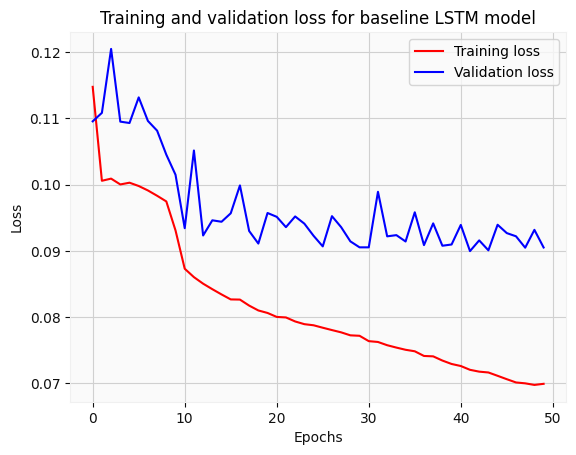

In [304]:
# approach 1
plot_loss(history_all, 'baseline LSTM model')

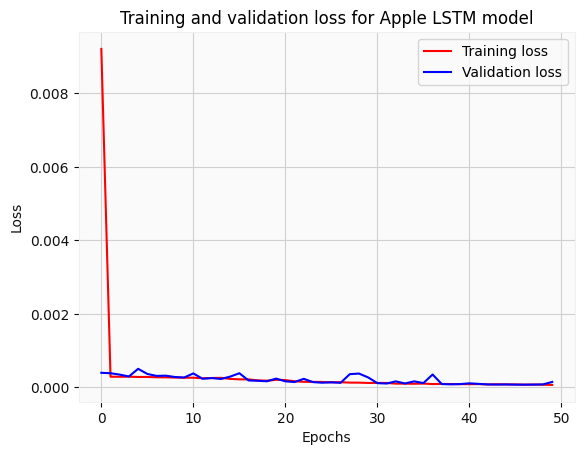

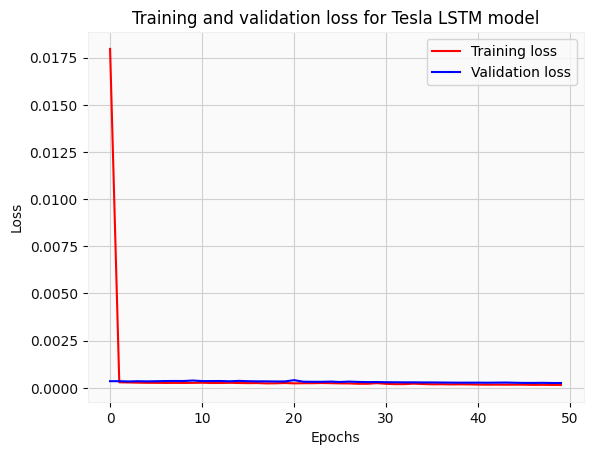

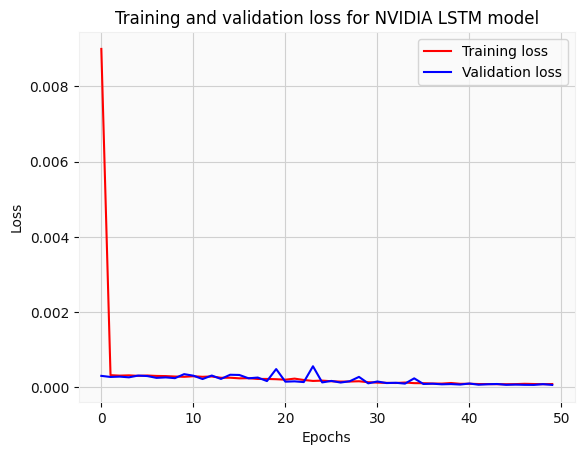

In [305]:
# approach 2
plot_loss(history_apple, 'Apple LSTM model')
plot_loss(history_tesla, 'Tesla LSTM model')
plot_loss(history_nvidia, 'NVIDIA LSTM model')


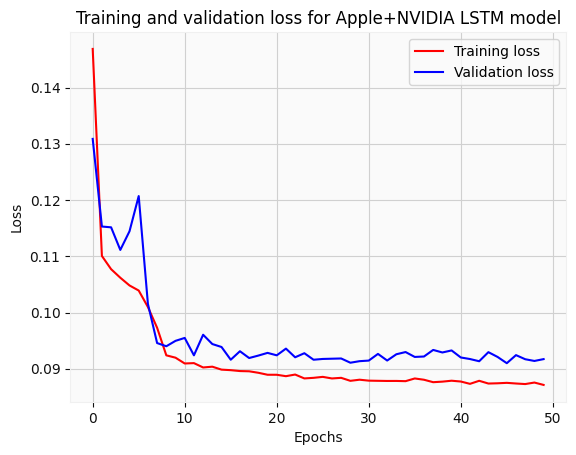

In [306]:
# approach 3
plot_loss(history_appl_nvda, 'Apple+NVIDIA LSTM model')

## 3.3 Model generalisation
Based on project requirement, we test the three trained models on their ability to generalise with new dataset. This is done by testing with each other's dataset


Interestingly,
- The Apple model performs best on the Nvidia dataset (lowest MSE) and worst on the Tesla dataset.

- Nvidia performs similarly on the Apple and Tesla datasets, with relatively close MSE values.

Numerically based on this metric, the ranking from best to worst generalization performance is Tesla Model, Nvidia Model, and Apple Model.

In [312]:
from sklearn.metrics import mean_squared_error

models = [model_apple, model_tesla, model_nvidia]
datasets = [(X_test_apple, y_test_apple, "Apple"), (X_test_tesla, y_test_tesla, "Tesla"), (X_test_nvidia, y_test_nvidia, "Nvidia")]

for i, model in enumerate(models):
    company_name = ["Apple", "Tesla", "Nvidia"][i]
    print(f"Evaluating {company_name} model:")
    for X_test, y_test, dataset_name in datasets:
        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate Mean Squared Error
        mse = mean_squared_error(y_test, y_pred)

        # Print the results
        print(f"  - MSE on {dataset_name} dataset: {mse}")

    print("\n")


Evaluating Apple model:
53/53 [==============================] - 0s 4ms/step
  - MSE on Apple dataset: 0.00012675152537880985
53/53 [==============================] - 0s 4ms/step
  - MSE on Tesla dataset: 0.00021404427004817464
53/53 [==============================] - 0s 4ms/step
  - MSE on Nvidia dataset: 0.00010555555713137814


Evaluating Tesla model:
53/53 [==============================] - 0s 4ms/step
  - MSE on Apple dataset: 0.00019943462388957449
53/53 [==============================] - 0s 5ms/step
  - MSE on Tesla dataset: 6.741438005524697e-05
53/53 [==============================] - 0s 5ms/step
  - MSE on Nvidia dataset: 0.00017339835855201925


Evaluating Nvidia model:
53/53 [==============================] - 0s 5ms/step
  - MSE on Apple dataset: 0.00017612186252291502
53/53 [==============================] - 0s 4ms/step
  - MSE on Tesla dataset: 0.00018819652468700623
53/53 [==============================] - 0s 3ms/step
  - MSE on Nvidia dataset: 0.00013523195203780564




# 4. Prediction submission

This part covers hourly stock price prediction on 12/11.
The submission format of the code is based on the structure of yfinance data.
The format is set as follows with 'Datetime' as index.
As for columns:
- Opening
- High
- Low
- Closing
- Company

## 4.1 Prediction
We extracted the test set from latest timestamp, so we use it for predicting next week.
Since we sorted it by date, the latest sequence is used as input.

In [400]:
def make_day_pred(model, sequence_to_predict, num_predictions):
    # Assume 'model' is your Keras/TensorFlow model

    # Reshape the sequence for prediction
    input_size = sequence_to_predict.shape[0]
    inputs = sequence_to_predict.reshape(1, input_size, -1)

    # Generate predictions for the specified number of time steps
    predictions = []
    for i in range(num_predictions):
        # Forward pass
        outputs = model.predict(inputs)

        # Save the prediction
        predictions.append(outputs[0])  # Save all output values

        # Update the input sequence for the next time step
        inputs = np.concatenate((inputs[:, 1:, :], outputs.reshape(1, 1, -1)), axis=1)

    return np.array(predictions)

# Apple
sequence_to_predict_apple = test_seq_apple[-1]
num_predictions = 241 # plus one for additional ending timestamp
predicted_sequence_apple = make_day_pred(model_apple, sequence_to_predict_apple, num_predictions)
print('Predicted Sequence for Apple:', predicted_sequence_apple)

# Nvidia
sequence_to_predict_nvidia = test_seq_nvidia[-1]
predicted_sequence_nvidia = make_day_pred(model_nvidia, sequence_to_predict_nvidia, num_predictions)
print('Predicted Sequence for Nvidia:', predicted_sequence_nvidia)

# Tesla
sequence_to_predict_tesla = test_seq_tesla[-1]
predicted_sequence_tesla = make_day_pred(model_tesla, sequence_to_predict_tesla, num_predictions)
print('Predicted Sequence for Tesla:', predicted_sequence_tesla)


1/1 [==============================] - 0s 30ms/step
Predicted Sequence for Apple: [[0.9134412  0.9099326  0.9032518  0.9102614 ]
 [0.90918446 0.90577763 0.8993418  0.90613574]
 [0.90442246 0.901197   0.8946792  0.9010628 ]
 [0.89999795 0.8969885  0.8901343  0.8962764 ]
 [0.89636767 0.8935236  0.8862253  0.892358  ]
 [0.8936485  0.8908993  0.8831692  0.8894874 ]
 [0.89170253 0.8889852  0.8809342  0.8875361 ]
 [0.8903414  0.88760626 0.8792849  0.8861948 ]
 [0.8892622  0.88645715 0.87807006 0.88520974]
 [0.88821566 0.885361   0.8769632  0.8842558 ]
 [0.88705087 0.884184   0.8757841  0.88318264]
 [0.8857287  0.882861   0.87451    0.88193756]
 [0.88427556 0.8814284  0.8731159  0.8805385 ]
 [0.8827491  0.8799369  0.87164325 0.87904286]
 [0.8812112  0.8784413  0.8701463  0.8775196 ]
 [0.8797124  0.87698454 0.8686737  0.8760267 ]
 [0.8782829  0.87559325 0.86725825 0.8746001 ]
 [0.87693286 0.87427557 0.8659148  0.8732549 ]
 [0.87565804 0.8730268  0.8646441  0.8719886 ]
 [0.87444526 0.87183577 0

In [401]:
# sanity checks
print(len(predicted_sequence_apple))
print(len(predicted_sequence_tesla))
print(len(predicted_sequence_nvidia))


241
241
241


## 4.2 Submission
We inverse transform them and select the hourly prediction. This is based on each company's scaler, with reference to its original data.

In [402]:
def inverse_transform(predictions, company, scalers):
    # Reshape the predictions array to match the shape during training
    predictions = np.array(predictions).reshape(-1, 4)  # Assuming 4 output values

    # Inverse transform the predictions using the corresponding scaler for the company
    scaler = scalers.get(company)
    if scaler is None:
        raise ValueError(f"No scaler found for company: {company}")

    predictions_inverse = scaler.inverse_transform(predictions)

    return predictions_inverse

# Create a dictionary to store scalers for each company
scalers = {}

# Loop through each company and fit a scaler to its data
for company in company_names:
    company_data = all_data[all_data['Company'] == company].copy()

    # Assuming 'Company' is the column used for grouping
    scaler = MinMaxScaler()
    scaler.fit(company_data.drop(columns=['Volume','Company']))  # Exclude non-numeric columns

    scalers[company] = scaler

In [376]:
#apply scalers to all companies
pred_seq_apple_inv = inverse_transform(predicted_sequence_apple, 'APPLE', scalers)
pred_seq_nvidia_inv = inverse_transform(predicted_sequence_nvidia, 'NVIDIA', scalers)
pred_seq_tesla_inv = inverse_transform(predicted_sequence_tesla, 'TESLA', scalers)

We put them into dataframe for submission with Datetime column set as index.

In [403]:
def create_dataframe(predictions, start_datetime, interval_minutes=2, company='APPLE'):
    # Calculate the Datetime values based on the start_datetime and interval
    datetimes = [start_datetime + timedelta(minutes=i * interval_minutes) for i in range(len(predictions))]

    # Format Datetime strings in the desired format
    formatted_datetimes = [dt.strftime('%Y-%m-%d %H:%M:%S%z') for dt in datetimes]

    # Create a DataFrame
    df = pd.DataFrame(predictions, columns=['Open', 'High', 'Low', 'Close'])

    # Add Datetime and Company columns
    df['Datetime'] = formatted_datetimes
    df['Company'] = company

    # Reorder columns
    df = df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Company']]

    return df

In [431]:
# Parameters
start_datetime = datetime(2023, 11, 13, 9, 30, 0)  # Replace this with the actual start datetime
interval_minutes = 2

# Fit into dataframe
df_predicted_apple_inverse = create_dataframe(pred_seq_apple_inv, start_datetime,
                                              interval_minutes, company='APPLE')
df_predicted_tesla_inverse = create_dataframe(pred_seq_tesla_inv, start_datetime,
                                              interval_minutes, company='TESLA')
df_predicted_nvidia_inverse = create_dataframe(pred_seq_nvidia_inv, start_datetime,
                                              interval_minutes, company='NVIDIA')

In [432]:
# Concatenate the three DataFrames
df_concatenated = pd.concat([df_predicted_apple_inverse,
                             df_predicted_tesla_inverse,
                             df_predicted_nvidia_inverse], ignore_index=True)

# Convert 'Datetime' column to datetime object if it's not already
df_concatenated['Datetime'] = pd.to_datetime(df_concatenated['Datetime'])

# Set 'Datetime' as the index
df_concatenated.set_index('Datetime', inplace=True)

# Resample the data hourly for each company and take the first value of each hour
df_hourly_apple = df_concatenated[df_concatenated['Company'] == 'APPLE'].resample('H').first()
df_hourly_tesla = df_concatenated[df_concatenated['Company'] == 'TESLA'].resample('H').first()
df_hourly_nvidia = df_concatenated[df_concatenated['Company'] == 'NVIDIA'].resample('H').first()

# Combine the three hourly DataFrames
df_hourly_combined = pd.concat([df_hourly_apple, df_hourly_tesla, df_hourly_nvidia])

# Filter the combined DataFrame to include predictions from 09:30 to 17:30
df_hourly_combined_filtered = df_hourly_combined.between_time('09:30', '17:30')

# Reset the index to make 'Datetime' a column again
df_hourly_combined_filtered.reset_index(inplace=True)

# Print or use the hourly DataFrame as needed
print(df_hourly_combined_filtered)


              Datetime        Open        High         Low       Close Company
0  2023-11-13 10:00:00  181.808014  181.873718  181.566727  181.744980   APPLE
1  2023-11-13 11:00:00  181.301666  181.375702  181.063736  181.243988   APPLE
2  2023-11-13 12:00:00  181.066132  181.143570  180.830154  181.011047   APPLE
3  2023-11-13 13:00:00  180.950073  181.029083  180.715073  180.896225   APPLE
4  2023-11-13 14:00:00  180.891357  180.971176  180.656860  180.838135   APPLE
5  2023-11-13 15:00:00  180.861282  180.941467  180.627014  180.808350   APPLE
6  2023-11-13 16:00:00  180.845734  180.926132  180.611618  180.792984   APPLE
7  2023-11-13 17:00:00  180.837692  180.918198  180.603653  180.785004   APPLE
8  2023-11-13 10:00:00  208.537766  208.867310  207.953110  208.435699   TESLA
9  2023-11-13 11:00:00  206.269150  206.626694  205.660065  206.167084   TESLA
10 2023-11-13 12:00:00  204.742188  205.119141  204.117966  204.641922   TESLA
11 2023-11-13 13:00:00  203.722351  204.112778  203.

In [433]:
# file submission
from google.colab import drive
drive.mount('/content/drive')
df_hourly_combined_filtered.to_csv('/content/drive/MyDrive/DCAI_lab/Foundation/stock_prediction/50015720_stock_pred.csv', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 5. Adding volume as attribute

Here we try to include volume for training.

In [456]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

train_apple_vol, test_apple_vol = split_and_scale_data(all_data, 'APPLE', scaler, include_volume=True)
train_tesla_vol, test_tesla_vol = split_and_scale_data(all_data, 'TESLA', scaler, include_volume=True)
train_nvidia_vol, test_nvidia_vol = split_and_scale_data(all_data, 'NVIDIA', scaler, include_volume=True)

train_seq_apple_vol = create_sequences(train_apple_vol, seq_length)
test_seq_apple_vol = create_sequences(test_apple_vol, seq_length)

train_seq_tesla_vol = create_sequences(train_tesla_vol, seq_length)
test_seq_tesla_vol = create_sequences(test_tesla_vol, seq_length)

train_seq_nvidia_vol = create_sequences(train_nvidia_vol, seq_length)
test_seq_nvidia_vol = create_sequences(test_nvidia_vol, seq_length)

X_train_apple_vol, y_train_apple_vol, X_test_apple_vol, y_test_apple_vol = prepare_data(train_seq_apple_vol, test_seq_apple_vol)
X_train_tesla_vol, y_train_tesla_vol, X_test_tesla_vol, y_test_tesla_vol = prepare_data(train_seq_tesla_vol, test_seq_tesla_vol)
X_train_nvidia_vol, y_train_nvidia_vol, X_test_nvidia_vol, y_test_nvidia_vol = prepare_data(train_seq_nvidia_vol, test_seq_nvidia_vol)


train_seq_apple = create_sequences(train_apple, seq_length) # approach 2
test_seq_apple = create_sequences(test_apple, seq_length)

train_seq_tesla = create_sequences(train_tesla, seq_length)
test_seq_tesla = create_sequences(test_tesla, seq_length)

train_seq_nvidia = create_sequences(train_nvidia, seq_length)
test_seq_nvidia = create_sequences(test_nvidia, seq_length)

X_train_apple, y_train_apple, X_test_apple, y_test_apple = prepare_data(train_seq_apple, test_seq_apple)
X_train_tesla, y_train_tesla, X_test_tesla, y_test_tesla = prepare_data(train_seq_tesla, test_seq_tesla)
X_train_nvidia, y_train_nvidia, X_test_nvidia, y_test_nvidia = prepare_data(train_seq_nvidia, test_seq_nvidia)

def build_and_train_model_vol(X_train, y_train, X_test, y_test):
    model = Sequential()

    # Adjust the input_shape parameter to match the number of features in your sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(units=5, activation='linear'))  # 5 output nodes for opening, closing, highest, lowest, volume
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model and save the training history
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    return model, history


## Model training

model_apple_vol, history_apple_vol = build_and_train_model_vol(X_train_apple_vol, y_train_apple_vol, X_test_apple_vol, y_test_apple_vol)
model_tesla_vol, history_tesla_vol = build_and_train_model_vol(X_train_tesla_vol, y_train_tesla_vol, X_test_tesla_vol, y_test_tesla_vol)
model_nvidia_vol, history_nvidia_vol = build_and_train_model_vol(X_train_nvidia_vol, y_train_nvidia_vol, X_test_nvidia_vol, y_test_nvidia_vol)



Epoch 1/50
124/124 [==============================] - 7s 17ms/step - loss: 0.0153 - val_loss: 8.6774e-04
Epoch 2/50
124/124 [==============================] - 1s 11ms/step - loss: 5.0076e-04 - val_loss: 7.8122e-04
Epoch 3/50
124/124 [==============================] - 1s 10ms/step - loss: 4.8257e-04 - val_loss: 8.5697e-04
Epoch 4/50
124/124 [==============================] - 1s 11ms/step - loss: 4.6632e-04 - val_loss: 7.0181e-04
Epoch 5/50
124/124 [==============================] - 1s 10ms/step - loss: 4.5468e-04 - val_loss: 7.6352e-04
Epoch 6/50
124/124 [==============================] - 2s 14ms/step - loss: 4.5548e-04 - val_loss: 7.1589e-04
Epoch 7/50
124/124 [==============================] - 2s 14ms/step - loss: 4.3800e-04 - val_loss: 6.5508e-04
Epoch 8/50
124/124 [==============================] - 2s 12ms/step - loss: 4.4512e-04 - val_loss: 8.2298e-04
Epoch 9/50
124/124 [==============================] - 1s 9ms/step - loss: 4.2699e-04 - val_loss: 6.6890e-04
Epoch 10/50
124/124 [===

Here we consider the four price attirbutes are sufficient to maintain a good performance, and adding volume may introudce error. Therefore, it is removed for model building.

In [458]:
from sklearn.metrics import mean_squared_error

# Function to evaluate model and print MSE
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error for {model_name}: {mse}')

# Evaluate models without volume
evaluate_model(model_apple, X_test_apple, y_test_apple, 'APPLE (Without Volume)')
evaluate_model(model_tesla, X_test_tesla, y_test_tesla, 'TESLA (Without Volume)')
evaluate_model(model_nvidia, X_test_nvidia, y_test_nvidia, 'NVIDIA (Without Volume)')

# Evaluate models with volume
evaluate_model(model_apple_vol, X_test_apple_vol, y_test_apple_vol, 'APPLE (With Volume)')
evaluate_model(model_tesla_vol, X_test_tesla_vol, y_test_tesla_vol, 'TESLA (With Volume)')
evaluate_model(model_nvidia_vol, X_test_nvidia_vol, y_test_nvidia_vol, 'NVIDIA (With Volume)')


53/53 [==============================] - 0s 5ms/step
Mean Squared Error for APPLE (Without Volume): 0.00012675152537880985
53/53 [==============================] - 0s 5ms/step
Mean Squared Error for TESLA (Without Volume): 6.741438005524697e-05
53/53 [==============================] - 0s 5ms/step
Mean Squared Error for NVIDIA (Without Volume): 0.00013523195203780564
53/53 [==============================] - 1s 3ms/step
Mean Squared Error for APPLE (With Volume): 0.00035154286103028623
53/53 [==============================] - 1s 3ms/step
Mean Squared Error for TESLA (With Volume): 0.00018501231887487076
53/53 [==============================] - 1s 3ms/step
Mean Squared Error for NVIDIA (With Volume): 0.0001871435283148635


Appendix: Requirements of this project
1. Data collection and preprocessing: Did you collect and preprocess the data effectively?
2. Data exploration: Did you explore the data using data visualization tools to identify patterns or trends?
3. Predictive model: Did you build an effective predictive model using machine learning algorithms?
4. Model evaluation: Did you evaluate the performance of the model using appropriate metrics?
5. Generalization: Did you test the model on a separate dataset to see how well it generalizes to new data?
6. Stock price prediction: Did you use your model to predict the future prices of the three stocks and test it with the latest/real-time stock dataset?